In [72]:
# https://colab.research.google.com/github/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb#scrollTo=HMqQTafXEaei

In [73]:
# !nvidia-smi

In [74]:
import transformers
from transformers import get_linear_schedule_with_warmup, RobertaConfig
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from collections import defaultdict
from textwrap import wrap
from datetime import datetime
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import re
# import emoji
# import nltk
# nltk.download('words')
# words = set(nltk.corpus.words.words())
EPOCHS = 1

In [75]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
current_time = datetime.now().strftime("%Y%m%d-%I_%M%p")
filename=  device.type + current_time
filename

'cuda20230601-02_14PM'

In [76]:
df1 =pd.read_csv('/data/jmharja/projects/robertaForTweetAnalysis/input/Tweets_Spring_Summer_2021_coded.csv',lineterminator='\n',skipinitialspace=True,)
# df1['label']= 1
# df1.drop(df1.columns[[0, 2,3,4]], axis=1, inplace=True)
df1.shape

(4467, 5)

In [77]:
df1_pos = df1.loc[(df1['Substance'] != 'X') & (df1['Use'] != 'X') & (df1['Intent'] != 'X')]
df1_neg = df1.loc[(df1['Substance'] == 'X') & (df1['Use'] == 'X') & (df1['Intent'] == 'X')]

df1_pos = df1_pos.drop(df1_pos.columns[[0, 2, 3, 4]], axis=1).copy()
df1_neg = df1_neg.drop(df1_neg.columns[[0, 2,3,4]], axis=1).copy()
df1_pos['label']= 1
df1_neg['label']= 0
df1_neg.shape,  df1_pos.shape

((3605, 2), (456, 2))

In [78]:
# prediction result reviewed by Dr. King added for re-training
df2 =pd.read_csv('/data/jmharja/projects/robertaForTweetAnalysis/input/ReviewedPrediction.csv',lineterminator='\n', skipinitialspace=True,)
df2.rename(columns = {'tweet':'Tweet'}, inplace = True)
df2 = df2.loc[:, ~df2.columns.str.contains('^Unnamed')]
df2.shape

(821, 4)

In [79]:
df2_pos = df2.loc[(df2['type'] == 1) | (df2['use'] == 1) | (df2['intent'] ==1)]
df2_neg = df2.loc[(df2['type'] != 1) & (df2['use'] != 1) & (df2['intent'] !=1)]
df2_pos = df2_pos.drop(df2_pos.columns[[2,3,1]], axis=1).copy()
df2_neg = df2_neg.drop(df2_neg.columns[[2,3,1]], axis=1).copy()
df2_pos['label']= 1
df2_neg['label']= 0
df2_neg.shape,  df2_pos.shape

((641, 2), (180, 2))

In [80]:
# iteration (predicted result added for re-training)
df3 =pd.read_csv('/data/jmharja/projects/robertaForTweetAnalysis/input/ReviewedPrediction_1.csv',lineterminator='\n', skipinitialspace=True,)
df3_pos= df3.loc[df3['label']==1]
df3_neg = df3.loc[df3['label']==0]
df3_neg.shape, df3_pos.shape

((412, 2), (710, 2))

In [81]:
# # predicted result from 202212 filtered by chatgpt added for retraining
# df4_pos =pd.read_csv('test_result/chatgpt/all_pos.csv',lineterminator='\n', skipinitialspace=True,)
# df4_neg =pd.read_csv('test_result/chatgpt/all_neg.csv',lineterminator='\n', skipinitialspace=True,)
# df4_pos.drop(df4_pos.columns[[0]], axis=1, inplace=True)
# df4_neg.drop(df4_neg.columns[[0]], axis=1, inplace=True)
# df4_pos['label']= 1
# df4_neg['label']= 0
# df4_neg.shape, df4_pos.shape

In [82]:
# df_pos = pd.concat([df1_pos, df2_pos, df3_pos, df4_pos])
# df_neg = pd.concat([df1_neg, df2_neg, df3_neg, df4_neg])
df_pos = pd.concat([df1_pos, df2_pos, df3_pos])
df_neg = pd.concat([df1_neg, df2_neg, df3_neg])
df_neg.shape,  df_pos.shape

((4658, 2), (1346, 2))

In [83]:
# foldername = '400Vs2000'
df1 = df_pos[:1150]
df2 = df_neg[:4575]
df = pd.concat([df1,df2])
df.shape

(5725, 2)

In [84]:
# df2 =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/2020_01_31_CleanedTweets.csv',
#                 lineterminator='\n',
#                 skipinitialspace=True
#                 )
# df2.drop(df2.columns[[0, 1]], axis=1, inplace=True)
# df2.rename({'text': 'Tweet'}, axis=1, inplace=True)
# df2['label'] = 0
# df4 = df2[1160000:]
# df2 = df2[:800]
# df4 = df4[:200]
# df2.shape, df4.shape

In [85]:
# df_test =pd.read_csv('/users/kent/jmaharja/drugAbuse/finetune/test_new.csv',
# #                    error_bad_lines=False,
#                 lineterminator='\n',
#                 skipinitialspace=True
#                 )
# df_test.drop(df_test.columns[[1, 2, 3]], axis=1, inplace=True)
# # df_test.rename({'text': 'Tweet'}, axis=1, inplace=True)
# # df_test['label']=/ 1
# df_test = df_test.rename(columns={df_test.columns[1]: 'label'})
df_test_neg = df_neg[4575:]
df_test_pos = df_pos[1150:]
df3 = pd.concat([df_test_pos,df_test_neg])
df3.shape

(279, 2)

# DATA PREPROCESSING

In [86]:
# #choosing sequence length
# token_lens = []
# for txt in df.Tweet:
#   tokens = tokenizer.encode(txt)
#   token_lens.append(len(tokens))
# sns.distplot(token_lens)
# plt.xlim([0, 200])
# plt.xlabel('Token count')

# MAX_LEN = 80

In [87]:
MAX_LEN = 128
from transformers import RobertaTokenizerFast
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

# Create the tokenizer from a trained one
tokenizer_folder = '/data/jmharja/projects/robertaForTweetAnalysis/output/oct2022/TokRoBERTa'
tokenizer = RobertaTokenizerFast.from_pretrained(tokenizer_folder, max_len=MAX_LEN)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'RobertaTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'RobertaTokenizerFast'.


In [88]:
from torch.utils.data import Dataset
class Tweet_DataSet(Dataset):
   def __init__(self, data, tokenizer, max_len):
    self.data = data
    self.data['Tweet'] = self.data['Tweet'].map(lambda x: self.cleaner(x))
    self.tokenizer = tokenizer
    self.max_len = max_len
    
  
   def __len__(self):
    return len(self.data)

   def cleaner(self, tweet):
#         print(tweet)
        tweet = re.sub("@[A-Za-z0-9]+","", tweet) #Remove @ sign
        tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
        tweet = " ".join(tweet.split())
        #     tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI) #Remove Emojis
        #     tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
        #     tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) \
        #          if w.lower() in words or not w.isalpha())
        return tweet
    
        
  
   def __getitem__(self, index:int):
    data_row = self.data.iloc[index]
    tweet = data_row.Tweet
    labels = data_row['label']
    encoding = tokenizer.encode_plus(tweet,
                                     None,
                                     max_length = MAX_LEN,
                                     truncation=True,
                                     pad_to_max_length=True,
                                     add_special_tokens=True,
                                     padding='max_length',
                                     return_token_type_ids=True)

    return {
      'tweet_text': tweet,
      'input_ids': torch.tensor(encoding.input_ids, dtype=torch.long),
      'attention_mask':  torch.tensor(encoding.attention_mask, dtype=torch.long),
      'token_type_ids': torch.tensor(encoding.token_type_ids, dtype=torch.long),
      'targets': torch.tensor(labels, dtype=torch.long)
    }

In [89]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
# df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_val = df_test
df_test = df3
df_train.shape, df_val.shape, df_test.shape

((5152, 2), (573, 2), (279, 2))

In [90]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = Tweet_DataSet(df,tokenizer=tokenizer,max_len=max_len)
  return DataLoader(ds, batch_size=batch_size,num_workers=4)

BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [91]:
# from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
# from transformers import RobertaModel, RobertaConfig, logging

class TweetModel(RobertaPreTrainedModel):
    def __init__(self, conf, n_classes):
        super(TweetModel, self).__init__(conf)
        self.roberta = transformers.RobertaModel.from_pretrained('/data/jmharja/projects/robertaForTweetAnalysis/output/oct2022/RoBERTaMLM/', config=conf)
        self.drop_out = nn.Dropout(0.5)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.classifier = nn.Linear(768, n_classes)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.roberta(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.drop_out(pooler)
        output = self.classifier(pooler)
        return output


In [92]:
config = RobertaConfig(
    vocab_size=8192,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
    hidden_size=768,
    pad_token_id=1
)

model = TweetModel(config, 2)
model = model.to(device)

Some weights of the model checkpoint at /data/jmharja/projects/robertaForTweetAnalysis/output/oct2022/RoBERTaMLM/ were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /data/jmharja/projects/robertaForTweetAnalysis/output/oct2022/RoBERTaMLM/ and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably T

In [93]:
#training
optimizer = optim.AdamW(model.parameters(), lr=1e-3) # old = 2e-5
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

In [94]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
     
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    targets = d["targets"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

    big_val, big_idx = torch.max(outputs, dim=1)
    correct_predictions += torch.sum(big_idx == targets)

    loss = loss_fn(outputs, targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double()/n_examples, np.mean(losses)

In [95]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
      )
      _, preds = torch.max(outputs, dim=1)
      correct_predictions += torch.sum(preds == targets)

      loss = loss_fn(outputs, targets)
      losses.append(loss.item())

  return correct_predictions.double()/n_examples, np.mean(losses)

In [96]:
from os.path import exists
# %%time

# set to True if you want to train the model
# otherwise use the existing trained model
FORCE_TRAIN = True

# download trained model
# !gdown --id 1QQ2d0_yFStL2rXz2eHoXpgRMvPWtMMeX

print(40*"*", 'Training')
current_time = datetime.now().strftime("%Y_%m_%d-%I_%M%p")
print(current_time)
history = defaultdict(list)
best_accuracy = 0
val_acc = 0 

for epoch in range(EPOCHS):


#   modelPath = "checkpoint/best_ftc_model_state.bin"
#   if (exists(modelPath) and FORCE_TRAIN == False ): # if model exists load it otherwise rebuild
#     torch.load(modelPath)
#     break # exit out of training
  

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, val_data_loader,loss_fn, device, len(df_val))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    curr_time = datetime.now().strftime("%Y_%m_%d-%I_%M%p")
    torch.save(model.state_dict(), 'checkpoint/'+ filename +'.bin')
    best_accuracy = val_acc

**************************************** Training
2023_06_01-02_14PM
Epoch 1/1
----------
Train loss 0.5367011271463418 accuracy 0.7874611801242235
Val   loss 0.555319455348783 accuracy 0.774869109947644



In [100]:
history['train_acc']

[tensor(0.7875, device='cuda:0', dtype=torch.float64)]

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1.05]);
plt.savefig('images/'+filename+'_training_hist.png')

In [ ]:
# torch.save(model.state_dict(), 'checkpoint/gpu32_best_ftc_model_state_'+ curr_time +'.bin')

In [101]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
test_acc.item()

0.2974910394265233

# PREDICTION


In [ ]:
# model.load_state_dict(torch.load('checkpoint/best_ftc_model_state2023_01_17-02_22PM.bin'))

In [102]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
      _, preds = torch.max(outputs, dim=1)
      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [103]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

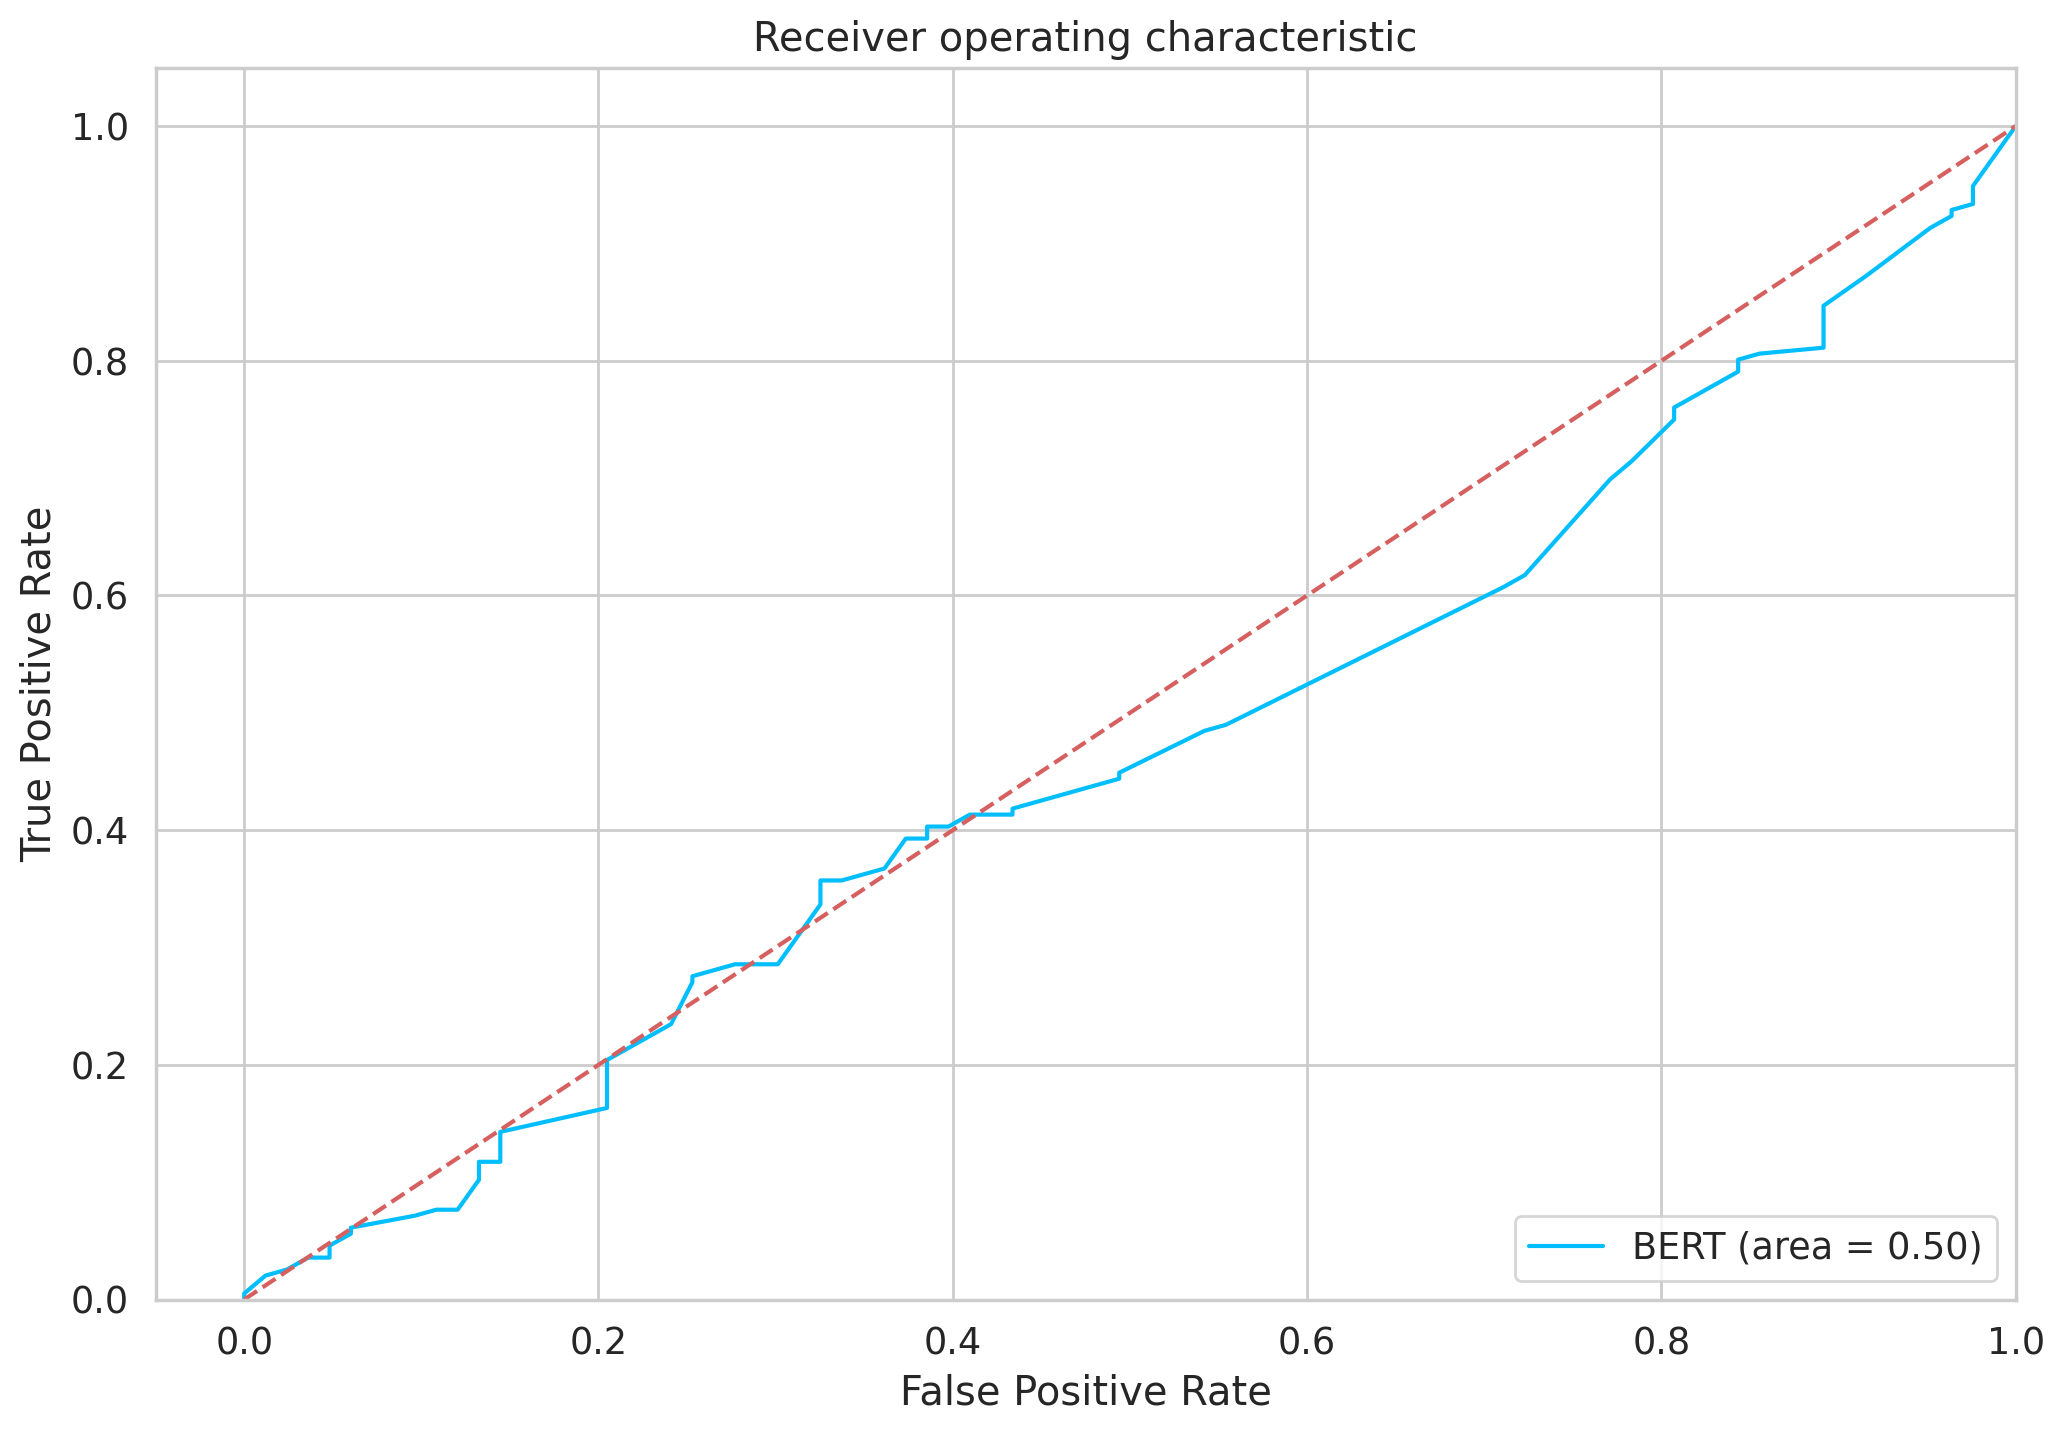

In [104]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test.numpy(), y_pred_probs[:, 1].numpy())
plt.figure()
plt.plot(fpr, tpr, label='BERT (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images/'+ filename +'_Log_ROC.png')
plt.show()

In [ ]:
y_pred_probs_pd = [y.numpy() for y in y_pred_probs]
someListOfLists = list(zip(y_review_texts, y_test.numpy(), y_pred.numpy(), y_pred_probs[:, 1:].numpy().squeeze(), y_pred_probs_pd ))
npa = np.asarray(someListOfLists)
dff = pd.DataFrame(someListOfLists, columns = ['readme', 'Real', 'Predicted', 'Pred-prob', 'All Pred-probs' ])
dff

In [ ]:
dff.to_csv('test_result/'+ filename + '_test.csv')

In [106]:
print(classification_report(y_test, y_pred, target_names=['Y', 'N']))

              precision    recall  f1-score   support

           Y       0.30      1.00      0.46        83
           N       0.00      0.00      0.00       196

    accuracy                           0.30       279
   macro avg       0.15      0.50      0.23       279
weighted avg       0.09      0.30      0.14       279



/home/jmaharja/anaconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmaharja/anaconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmaharja/anaconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

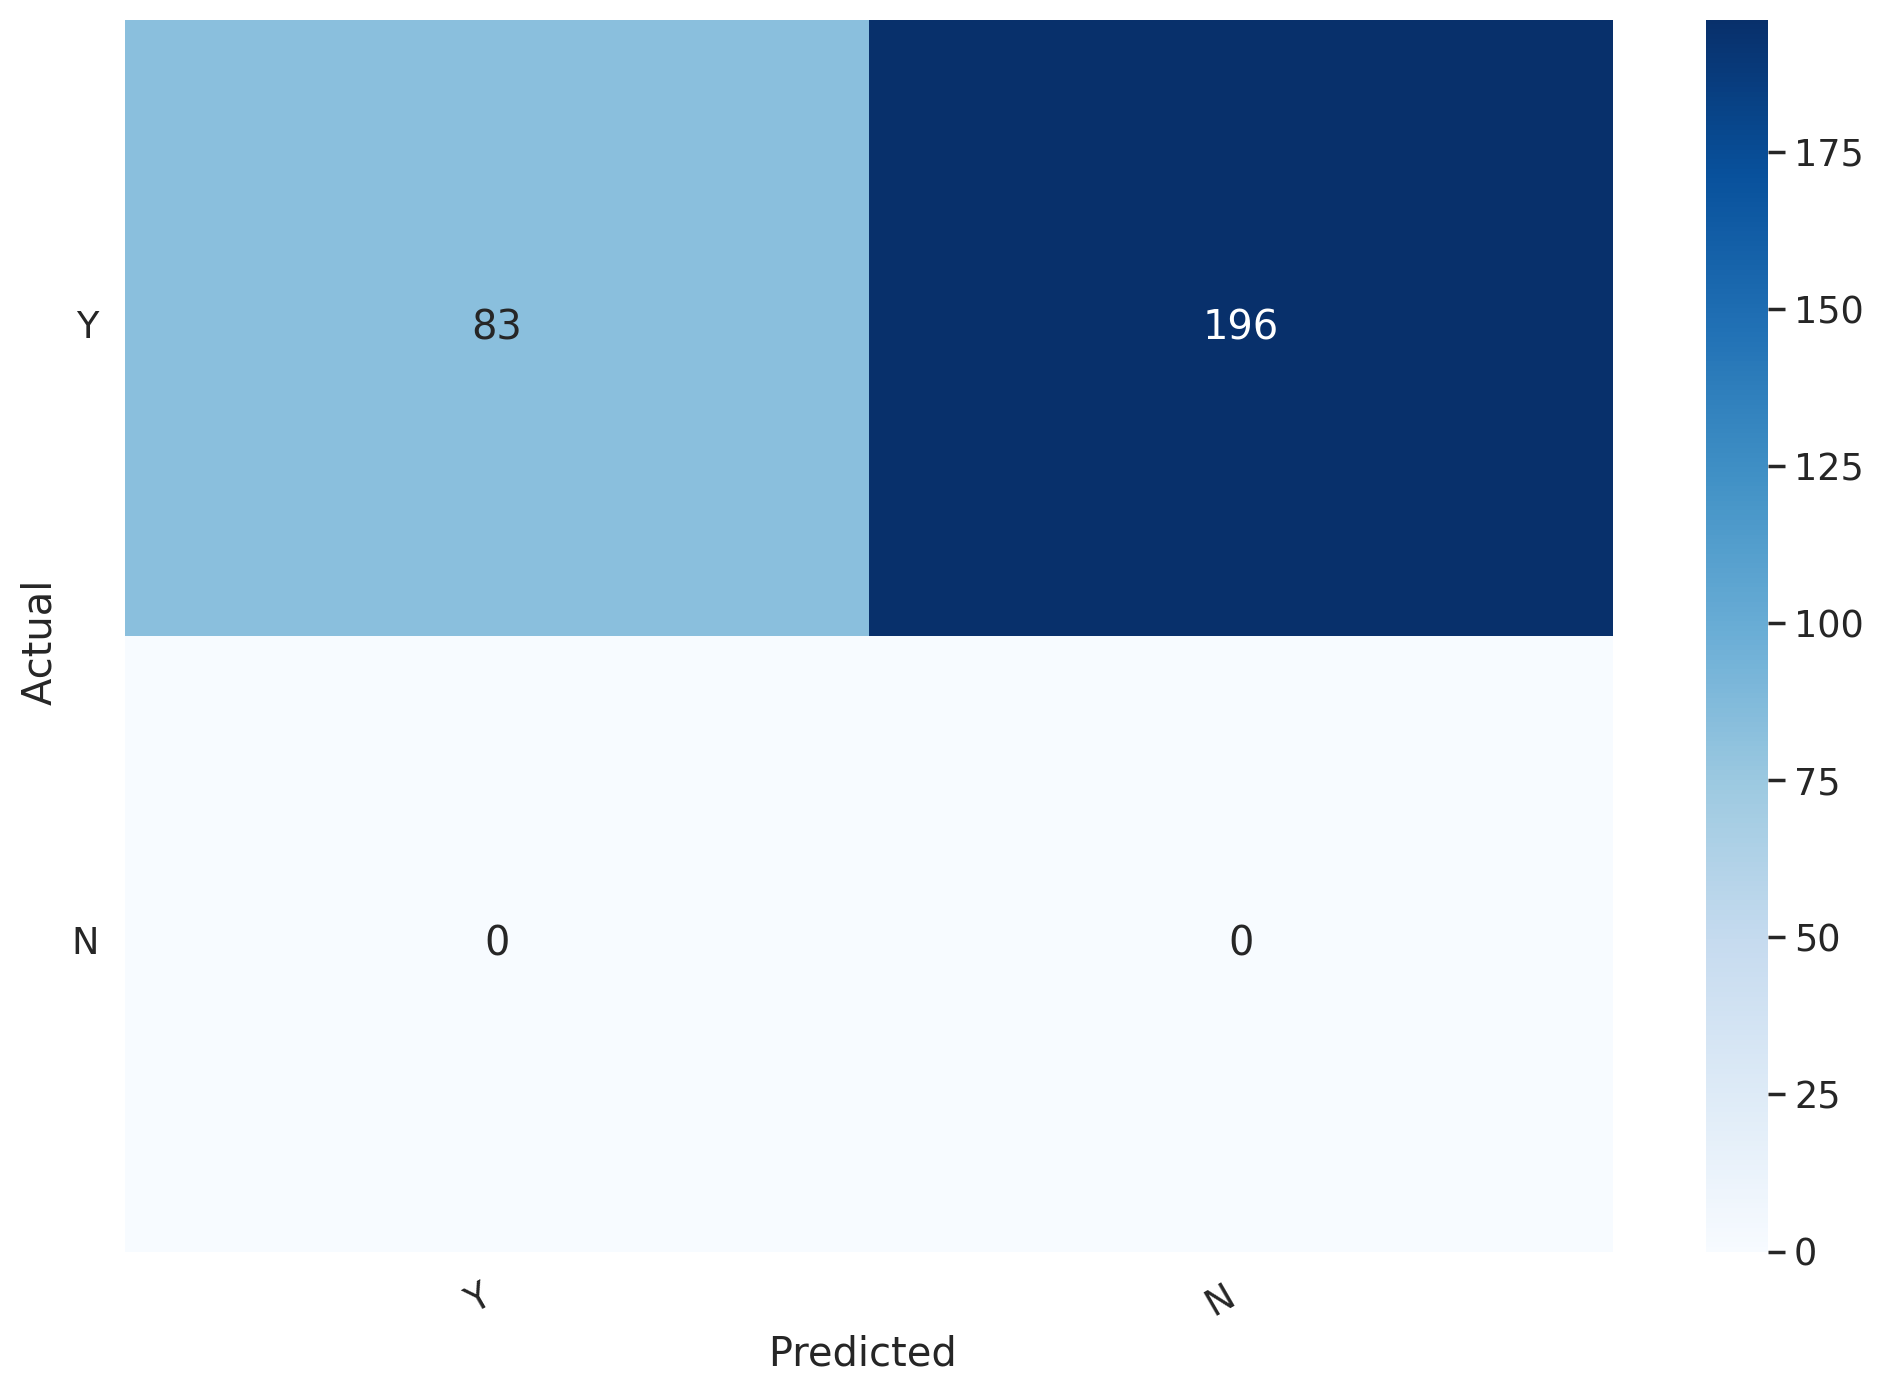

In [109]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('Actual ')
  plt.xlabel('Predicted ')
  plt.savefig('images/'+ current_time + '_cm.png')


cm = confusion_matrix(y_pred, y_test)
df_cm = pd.DataFrame(cm, index=['Y', 'N'], columns=['Y', 'N'])
show_confusion_matrix(df_cm)

# PREDICTION ON REAL DATA

In [ ]:
df_pred =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/2020_01_01.csv',lineterminator='\n',   skipinitialspace=True)
df_pred.drop(df_pred.columns[[0, 1,2, 4]], axis=1, inplace=True)
df_pred = df_pred.rename(columns={df_pred.columns[0]: 'Tweet'})
df_pred['label']= 1

In [ ]:
## df_pred =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/2022_11.csv',lineterminator='\n',skipinitialspace=True)
# df_pred = pd.read_fwf('/users/kent/jmaharja/drugAbuse/input/2022_11.csv')
# df_pred['label']= 1

In [ ]:
df_pred.shape

In [ ]:
# from sklearn.utils import shuffle
# df_pred = shuffle(df_pred)

In [ ]:
# df_pred = df_pred[:150000]
# df_pred = df_pred[150000:160000]
# df_pred = df_pred[160000:170000]
# df_pred = df_pred[170000:180000]
# df_pred = df_pred[180000:190000]
# df_pred = df_pred[190000:200000]
# df_pred = df_pred[230000:240000]
df_pred= df_pred[250000:260000]
# df_pred = df_pred[1200:2000]

In [ ]:
pred_data_loader = create_data_loader(df_pred, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, pred_data_loader)

In [ ]:
y_pred_probs_pd = [y.numpy() for y in y_pred_probs]
someListOfLists = list(zip(y_review_texts, y_test.numpy(), y_pred.numpy(), y_pred_probs[:, 1:].numpy().squeeze(), y_pred_probs_pd ))
npa = np.asarray(someListOfLists)
dff = pd.DataFrame(someListOfLists, columns = ['tweet', 'Real', 'Predicted', 'Pred-prob', 'All Pred-probs' ])
dff

In [ ]:
cm = confusion_matrix(y_pred, y_test)
df_cm = pd.DataFrame(cm, index=['Y', 'N'], columns=['Y', 'N'])
show_confusion_matrix(df_cm)

In [ ]:
# dff.to_csv('test_result/'+ current_time + 'prediction_result.csv')

In [ ]:
dff[dff['Predicted']==1]

In [ ]:
dff[dff['Predicted']==0]

In [ ]:
ones = dff[dff['Predicted']==1]['tweet']
ones.to_csv('test_result/'+ filename+'_ones.csv')

In [ ]:
# zeros = dff[dff['Predicted']==0]['tweet']
# zeros.to_csv('test_result/2023_neg.csv')

In [ ]:
dff[[ "tweet", "Predicted"]].to_csv('test_result/'+ filename+"_pred.csv)

In [ ]:
current_time

# POST REVIEW

In [ ]:
# ones.tweet.tolist()

# ' '.join(ones['tweet'].tolist())
# ones.tweet.str.cat(sep=', ')